In [1]:
import os
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
# setup pytorch gpu
print(torch.cuda.is_available())
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
12.1


In [3]:
#get file names
rotation_files = glob.glob('data\processed\*rotations*.pkl')
rotation_files[0].split('\\')[1:]
rotation_files = [x.split('\\')[1] + '/' + x.split('\\')[-1][:-6] for x in rotation_files]
#remove duplicates
rotation_files = set(rotation_files)

In [4]:
#load saved files

def file_loader(fname, reformat):
    """
    Loads saved data (in this specific project)
    """
    with open(f'./data/{fname}_x.pkl', 'rb') as f:
        firing_rates = pickle.load(f)
    with open(f'./data/{fname}_y.pkl', 'rb') as f:
        y_np = pickle.load(f)
    print(f'loaded data: X ({firing_rates.shape}), y ({y_np.shape})')
    
    num_cats = len(np.unique(y_np))

    if reformat:
        #format X as tensor of reordered dims to run CNNs
        firing_rates = torch.from_numpy(firing_rates).permute(2, 0, 1) 
        firing_rates = firing_rates.to(torch.float32)
        #don't format y here to keep dims for later
        y = y_np
    else:
        y = y_np

    return firing_rates, y, num_cats

firing_rates_all = []
ys = []
nums_cats = []

for fname in rotation_files:
    firing_rates, y, num_cats = file_loader(fname, reformat=True)
    firing_rates_all.append(firing_rates)
    ys.append(y)
    nums_cats.append(num_cats)

loaded data: X ((3645, 73, 252)), y ((3645,))
loaded data: X ((9452, 93, 252)), y ((9452,))
loaded data: X ((9448, 89, 252)), y ((9448,))
loaded data: X ((9451, 38, 252)), y ((9451,))
loaded data: X ((9454, 73, 252)), y ((9454,))
loaded data: X ((3645, 125, 252)), y ((3645,))
loaded data: X ((3645, 49, 252)), y ((3645,))
loaded data: X ((9452, 114, 252)), y ((9452,))
loaded data: X ((3645, 69, 252)), y ((3645,))
loaded data: X ((3645, 81, 252)), y ((3645,))


In [5]:
#join ys
y = np.concat(ys)# #format y as one hot encoding
y = F.one_hot(torch.from_numpy(y).to(torch.int64))
y = y.to(torch.float32)

In [6]:
# standardize dims by size
min_size = np.min([rates.shape[2] for rates in firing_rates_all])
num_cats = np.max([cats for cats in nums_cats])
print(f'the lowest amount of neurons to standardize to: {min_size}\n number of categories in data: {num_cats}')

the lowest amount of neurons to standardize to: 38
 number of categories in data: 7


In [ ]:
#standardize data to min size
#ensure that most active units are kept: they are sorted by firing rate
firing_rates_all = [rate[:,:,-min_size:] for rate in firing_rates_all]

In [8]:
for rate in firing_rates_all:
    print(rate.shape)
#the neurons should be sorted - check 

torch.Size([252, 3645, 38])
torch.Size([252, 9452, 38])
torch.Size([252, 9448, 38])
torch.Size([252, 9451, 38])
torch.Size([252, 9454, 38])
torch.Size([252, 3645, 38])
torch.Size([252, 3645, 38])
torch.Size([252, 9452, 38])
torch.Size([252, 3645, 38])
torch.Size([252, 3645, 38])


torch.Size([252, 3645, 38])


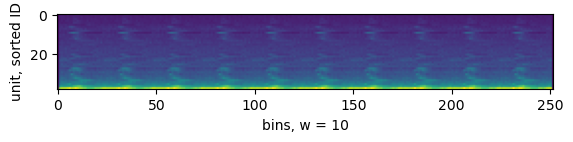

torch.Size([252, 9452, 38])


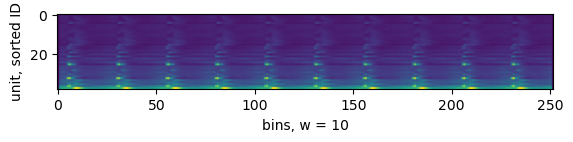

torch.Size([252, 9448, 38])


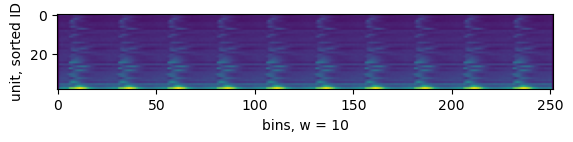

torch.Size([252, 9451, 38])


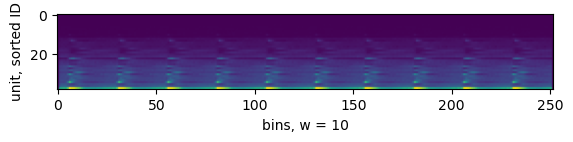

torch.Size([252, 9454, 38])


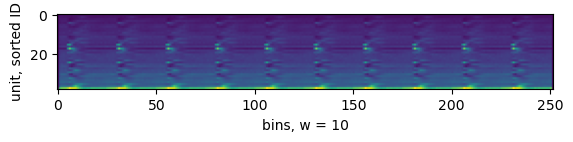

torch.Size([252, 3645, 38])


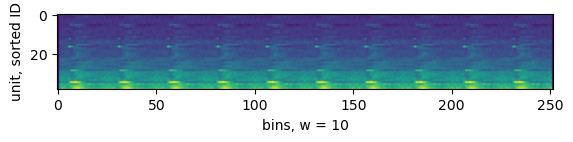

torch.Size([252, 3645, 38])


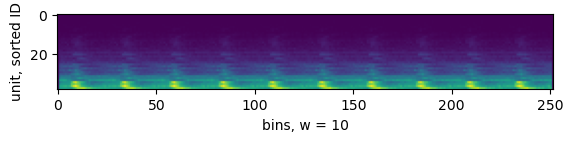

torch.Size([252, 9452, 38])


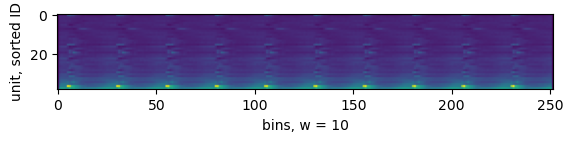

torch.Size([252, 3645, 38])


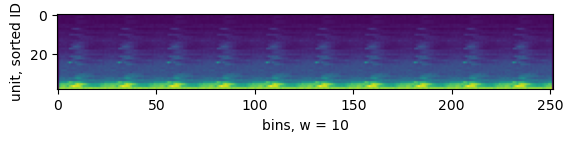

torch.Size([252, 3645, 38])


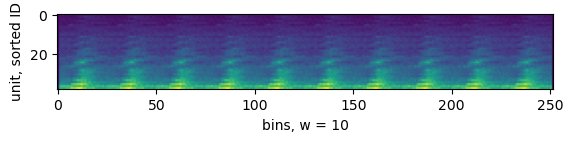

In [9]:
for rate in firing_rates_all:
    fig, ax = plt.subplots()
    print(rate.shape)
    ax.imshow(torch.mean(rate, dim= 1).T)
    ax.set(xlabel = 'bins, w = 10', ylabel = 'unit, sorted ID')
    plt.show()

In [10]:
#stack data
firing_rates = torch.cat(firing_rates_all, dim = 1)

In [11]:
#train test split
train_split = .8
all_ids = np.arange(firing_rates.shape[1])
np.random.shuffle(all_ids)
train_ids = all_ids[0:int(len(all_ids) * train_split)]
test_ids = all_ids[int(len(all_ids) * train_split):-1]

In [14]:
n_neurons = firing_rates.shape[-1] #number of units: size of input layer
n_bins = firing_rates.shape[0] #always 252 when defined as before
output_cats = num_cats #7cats here

#param for dataloader
batch_size = 32

n_comps = 7 #n of latent comps to try
learning_rate = 1e-3 #big LR to converge quickly (hopefully)
lambda_l2 = 5e-3 #big l2 regularization
num_epochs = 100 #100 definitely enough, but after ~50 slows down considerably if lr=1e-4. 
#with lr=1e-3 10 might be enough
earlystop_criterion = 20 #how many iters of loss worsening before stopping

In [15]:
#define model architecture
class Net(nn.Module):
    def __init__(self, n_comps, n_neurons, output_cats):
        super(Net, self).__init__()
        
        #layers
        #1st conv -> relu -> maxpool block 
        #size: 
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 2),
            nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        )
        #2nd conv -> relu -> maxpool block
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 2),
            nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        )

        # get the flattened size by using a dummy tensor of the same size
        dummy = torch.zeros(1, 1, n_bins, n_neurons)
        out = self.conv2(self.conv1(dummy))
        flattened_size = torch.flatten(out, 1).shape[1]

        #add a dropout layer
        self.dropout = nn.Dropout(p = 0.2)
        #1st fully connected layer for flattened data
        self.fc1 = nn.Linear(flattened_size, n_comps) #here, layer size depends on input data
        #2nd fully connected layer for dim reduction
        self.fc2 = nn.Linear(n_comps, output_cats)
    
    def forward(self, x):
        x = self.conv1(x)#conv
        x = self.conv2(x)#conv
        x = torch.flatten(x, 1) #flatten params
        x = self.dropout(x)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

In [16]:
class NeuralData(Dataset):
    def __init__(self, train = True):
        if train:
            self.firing_rate = firing_rates[:, train_ids, :]
            self.labels = y[train_ids]
        else:
            self.firing_rate = firing_rates[:, test_ids, :]
            self.labels = y[test_ids]
    
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        rate = self.firing_rate[:, idx]
        # rate = torch.sum(self.firing_rate, axis = 0)[idx]
        label = self.labels[idx]
        return rate, label
    
train_data = NeuralData(train = True)
test_data = NeuralData(train = False)

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [17]:
comps_to_try = [7]
accs = []
losses = []

for n_comps in comps_to_try:
    train_data = NeuralData(train = True)
    test_data = NeuralData(train = False)

    train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)
    #create model
    model = Net(n_comps = n_comps, n_neurons = n_neurons, output_cats = output_cats)

    #loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    loss_list = []
    loss_increase = 0
    prev_loss = 5

    #train
    for epoch in tqdm.tqdm(range(num_epochs)):
        #iterate through train data
        for rate, label in train_loader:
            rate = rate.unsqueeze(1)
            #forward pass 
            pred = model(rate)
            
            l2 = 0
            for p in model.parameters():
                l2 += torch.sum(p ** 2)
            loss = criterion(pred, label) + lambda_l2 * l2
            loss_list.append(loss.item())
            
            #early stopping
            if loss > prev_loss:
                loss_increase += 1
                prev_loss = loss
                if loss_increase > earlystop_criterion:
                    print(f'Early stop at epoch {epoch}, loss = {loss}, didn\'t improve for {earlystop_criterion} iterations')            
            else:
                loss_increase = 0
                prev_loss = loss
                
            #backprop
            optimizer.zero_grad() #zero out grads
            loss.backward() #calculate grad
            optimizer.step() #take step

        print(f'epoch: {epoch}, loss: {loss}')
            
    # testing
    model.eval()
    model.to(device)
    real_labels, predicted_labels = [], []
    with torch.no_grad():
        correct = 0
        total = 0
        for rate, labels in test_loader:
            #load labels
            rate, labels = rate.to(device), labels.to(device)
            rate = rate.unsqueeze(1)
            val, labels = torch.max(labels.data, 1)
            real_labels += list(labels.cpu().numpy())
            #get preds
            preds = model(rate)
            val, predicted = torch.max(preds.data, 1)
            predicted_labels += list(predicted.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accs.append((correct / total)*100)
        losses.append(loss_list)
        print(f"test acc from rates using {n_comps} hidden dims: {(correct / total)*100:.3f}%")

  1%|          | 1/100 [00:28<46:53, 28.41s/it]

epoch: 0, loss: 2.077476978302002


  2%|▏         | 2/100 [00:56<45:40, 27.97s/it]

epoch: 1, loss: 1.9456926584243774


  3%|▎         | 3/100 [01:26<47:20, 29.28s/it]

epoch: 2, loss: 1.7956342697143555


  4%|▍         | 4/100 [01:55<46:25, 29.01s/it]

epoch: 3, loss: 2.00801157951355


  5%|▌         | 5/100 [02:23<45:14, 28.57s/it]

epoch: 4, loss: 1.1609344482421875


  6%|▌         | 6/100 [02:50<44:09, 28.18s/it]

epoch: 5, loss: 1.2721055746078491


  7%|▋         | 7/100 [03:18<43:21, 27.98s/it]

epoch: 6, loss: 2.030156135559082


  8%|▊         | 8/100 [03:45<42:44, 27.87s/it]

epoch: 7, loss: 1.2098866701126099


  9%|▉         | 9/100 [04:13<42:03, 27.73s/it]

epoch: 8, loss: 1.2599576711654663


 10%|█         | 10/100 [04:40<41:28, 27.65s/it]

epoch: 9, loss: 1.3869929313659668


 11%|█         | 11/100 [05:08<40:55, 27.59s/it]

epoch: 10, loss: 1.2279820442199707


 12%|█▏        | 12/100 [05:35<40:23, 27.54s/it]

epoch: 11, loss: 2.289266347885132


 13%|█▎        | 13/100 [06:03<39:56, 27.55s/it]

epoch: 12, loss: 2.210902690887451


 14%|█▍        | 14/100 [06:30<39:26, 27.52s/it]

epoch: 13, loss: 1.2871956825256348


 15%|█▌        | 15/100 [06:58<39:00, 27.53s/it]

epoch: 14, loss: 1.2647491693496704


 16%|█▌        | 16/100 [07:25<38:31, 27.52s/it]

epoch: 15, loss: 2.9045732021331787


 17%|█▋        | 17/100 [07:53<38:05, 27.53s/it]

epoch: 16, loss: 2.0846030712127686


 18%|█▊        | 18/100 [08:20<37:37, 27.53s/it]

epoch: 17, loss: 1.5994518995285034


 19%|█▉        | 19/100 [08:48<37:07, 27.50s/it]

epoch: 18, loss: 1.951416254043579


 20%|██        | 20/100 [09:15<36:38, 27.48s/it]

epoch: 19, loss: 1.0773658752441406


 21%|██        | 21/100 [09:53<40:15, 30.58s/it]

epoch: 20, loss: 1.2304699420928955


 22%|██▏       | 22/100 [10:21<38:35, 29.69s/it]

epoch: 21, loss: 1.2523669004440308


 23%|██▎       | 23/100 [10:48<37:15, 29.03s/it]

epoch: 22, loss: 1.5293816328048706


 24%|██▍       | 24/100 [11:16<36:13, 28.60s/it]

epoch: 23, loss: 1.2063729763031006


 25%|██▌       | 25/100 [11:43<35:22, 28.30s/it]

epoch: 24, loss: 1.3818368911743164


 26%|██▌       | 26/100 [12:11<34:41, 28.12s/it]

epoch: 25, loss: 1.272348403930664


 27%|██▋       | 27/100 [12:39<34:04, 28.01s/it]

epoch: 26, loss: 1.2692567110061646


 28%|██▊       | 28/100 [13:07<33:32, 27.95s/it]

epoch: 27, loss: 1.2624118328094482


 29%|██▉       | 29/100 [13:34<32:58, 27.87s/it]

epoch: 28, loss: 1.2744765281677246


 30%|███       | 30/100 [14:04<33:12, 28.47s/it]

epoch: 29, loss: 1.1744657754898071


 31%|███       | 31/100 [14:39<35:01, 30.46s/it]

epoch: 30, loss: 1.1680142879486084


 32%|███▏      | 32/100 [15:13<35:46, 31.56s/it]

epoch: 31, loss: 1.8666903972625732


 33%|███▎      | 33/100 [15:47<36:02, 32.27s/it]

epoch: 32, loss: 2.3023929595947266


 34%|███▍      | 34/100 [16:21<35:59, 32.73s/it]

epoch: 33, loss: 1.3440823554992676


 35%|███▌      | 35/100 [16:55<35:42, 32.96s/it]

epoch: 34, loss: 1.0061618089675903


 36%|███▌      | 36/100 [17:28<35:23, 33.18s/it]

epoch: 35, loss: 2.9814929962158203


 37%|███▋      | 37/100 [18:02<35:01, 33.35s/it]

epoch: 36, loss: 3.2635350227355957


 38%|███▊      | 38/100 [18:36<34:31, 33.41s/it]

epoch: 37, loss: 1.474900245666504


 39%|███▉      | 39/100 [19:09<34:06, 33.55s/it]

epoch: 38, loss: 1.8095989227294922


 40%|████      | 40/100 [19:43<33:39, 33.65s/it]

epoch: 39, loss: 1.8854836225509644


 41%|████      | 41/100 [20:17<33:06, 33.66s/it]

epoch: 40, loss: 2.0628674030303955


 42%|████▏     | 42/100 [20:51<32:30, 33.63s/it]

epoch: 41, loss: 1.2352617979049683


 43%|████▎     | 43/100 [21:24<31:58, 33.66s/it]

epoch: 42, loss: 1.6458402872085571


 44%|████▍     | 44/100 [21:58<31:19, 33.57s/it]

epoch: 43, loss: 1.0209426879882812


 45%|████▌     | 45/100 [22:31<30:42, 33.50s/it]

epoch: 44, loss: 1.2176203727722168


 46%|████▌     | 46/100 [23:05<30:14, 33.59s/it]

epoch: 45, loss: 1.168245553970337


 47%|████▋     | 47/100 [23:39<29:45, 33.69s/it]

epoch: 46, loss: 1.8807532787322998


 48%|████▊     | 48/100 [24:12<29:09, 33.65s/it]

epoch: 47, loss: 1.191817283630371


 49%|████▉     | 49/100 [24:46<28:33, 33.59s/it]

epoch: 48, loss: 3.512333869934082


 50%|█████     | 50/100 [25:19<28:00, 33.62s/it]

epoch: 49, loss: 1.4800162315368652


 51%|█████     | 51/100 [25:53<27:26, 33.61s/it]

epoch: 50, loss: 1.9042128324508667


 52%|█████▏    | 52/100 [26:26<26:48, 33.52s/it]

epoch: 51, loss: 1.2900006771087646


 53%|█████▎    | 53/100 [27:00<26:13, 33.47s/it]

epoch: 52, loss: 1.3374887704849243


 54%|█████▍    | 54/100 [27:33<25:40, 33.48s/it]

epoch: 53, loss: 1.2820169925689697


 55%|█████▌    | 55/100 [28:06<25:01, 33.36s/it]

epoch: 54, loss: 2.21227765083313


 56%|█████▌    | 56/100 [28:40<24:31, 33.45s/it]

epoch: 55, loss: 2.049262046813965


 57%|█████▋    | 57/100 [29:14<24:01, 33.53s/it]

epoch: 56, loss: 1.9883594512939453


 58%|█████▊    | 58/100 [29:47<23:29, 33.56s/it]

epoch: 57, loss: 2.02278733253479


 59%|█████▉    | 59/100 [30:21<22:57, 33.61s/it]

epoch: 58, loss: 1.7290880680084229


 60%|██████    | 60/100 [30:54<22:21, 33.54s/it]

epoch: 59, loss: 1.5447875261306763


 61%|██████    | 61/100 [31:29<21:55, 33.72s/it]

epoch: 60, loss: 1.679587483406067


 62%|██████▏   | 62/100 [32:02<21:18, 33.65s/it]

epoch: 61, loss: 1.7295552492141724


 63%|██████▎   | 63/100 [32:35<20:42, 33.58s/it]

epoch: 62, loss: 1.3770947456359863


 64%|██████▍   | 64/100 [33:09<20:08, 33.57s/it]

epoch: 63, loss: 1.1395310163497925


 65%|██████▌   | 65/100 [33:43<19:35, 33.57s/it]

epoch: 64, loss: 1.1466795206069946


 66%|██████▌   | 66/100 [34:16<19:00, 33.54s/it]

epoch: 65, loss: 1.3117657899856567


 67%|██████▋   | 67/100 [34:44<17:28, 31.78s/it]

epoch: 66, loss: 2.6465983390808105


 68%|██████▊   | 68/100 [35:11<16:14, 30.46s/it]

epoch: 67, loss: 1.3527456521987915


 69%|██████▉   | 69/100 [35:38<15:15, 29.53s/it]

epoch: 68, loss: 1.3711289167404175


 70%|███████   | 70/100 [36:06<14:26, 28.88s/it]

epoch: 69, loss: 1.2484711408615112


 71%|███████   | 71/100 [36:33<13:44, 28.43s/it]

epoch: 70, loss: 1.3675737380981445


 72%|███████▏  | 72/100 [37:01<13:07, 28.13s/it]

epoch: 71, loss: 1.3680016994476318


 73%|███████▎  | 73/100 [37:28<12:33, 27.90s/it]

epoch: 72, loss: 1.349716305732727


 74%|███████▍  | 74/100 [37:55<12:01, 27.76s/it]

epoch: 73, loss: 1.2127459049224854


 75%|███████▌  | 75/100 [38:24<11:36, 27.87s/it]

epoch: 74, loss: 1.2427226305007935


 76%|███████▌  | 76/100 [38:57<11:52, 29.69s/it]

epoch: 75, loss: 1.8540610074996948


 77%|███████▋  | 77/100 [39:31<11:51, 30.92s/it]

epoch: 76, loss: 1.829555869102478


 78%|███████▊  | 78/100 [40:05<11:38, 31.75s/it]

epoch: 77, loss: 2.575737237930298


 79%|███████▉  | 79/100 [40:39<11:19, 32.35s/it]

epoch: 78, loss: 1.472888469696045


 80%|████████  | 80/100 [41:12<10:53, 32.68s/it]

epoch: 79, loss: 1.73176109790802


 81%|████████  | 81/100 [41:46<10:27, 33.00s/it]

epoch: 80, loss: 1.2271002531051636


 82%|████████▏ | 82/100 [42:19<09:57, 33.18s/it]

epoch: 81, loss: 2.630969285964966


 83%|████████▎ | 83/100 [42:53<09:26, 33.35s/it]

epoch: 82, loss: 1.3097469806671143


 84%|████████▍ | 84/100 [43:27<08:55, 33.45s/it]

epoch: 83, loss: 1.4294723272323608


 85%|████████▌ | 85/100 [44:00<08:22, 33.48s/it]

epoch: 84, loss: 2.052255153656006


 86%|████████▌ | 86/100 [44:34<07:49, 33.53s/it]

epoch: 85, loss: 1.2227706909179688


 87%|████████▋ | 87/100 [45:08<07:15, 33.49s/it]

epoch: 86, loss: 1.7729992866516113


 88%|████████▊ | 88/100 [45:40<06:39, 33.28s/it]

epoch: 87, loss: 1.291374921798706


 89%|████████▉ | 89/100 [46:07<05:45, 31.37s/it]

epoch: 88, loss: 1.2459696531295776


 90%|█████████ | 90/100 [46:34<05:00, 30.08s/it]

epoch: 89, loss: 1.4189664125442505


 91%|█████████ | 91/100 [47:02<04:23, 29.25s/it]

epoch: 90, loss: 1.2501925230026245


 92%|█████████▏| 92/100 [47:29<03:49, 28.67s/it]

epoch: 91, loss: 1.4263389110565186


 93%|█████████▎| 93/100 [47:56<03:17, 28.28s/it]

epoch: 92, loss: 1.4915516376495361


 94%|█████████▍| 94/100 [48:24<02:47, 28.00s/it]

epoch: 93, loss: 1.1135826110839844


 95%|█████████▌| 95/100 [48:51<02:19, 27.80s/it]

epoch: 94, loss: 1.9138370752334595


 96%|█████████▌| 96/100 [49:18<01:50, 27.67s/it]

epoch: 95, loss: 1.5447884798049927


 97%|█████████▋| 97/100 [49:47<01:24, 28.05s/it]

epoch: 96, loss: 2.239032506942749


 98%|█████████▊| 98/100 [50:21<00:59, 29.76s/it]

epoch: 97, loss: 1.53720223903656


 99%|█████████▉| 99/100 [50:55<00:30, 30.89s/it]

epoch: 98, loss: 2.4823296070098877


100%|██████████| 100/100 [51:29<00:00, 30.89s/it]

epoch: 99, loss: 1.314610242843628


test acc from rates using 7 hidden dims: 27.230%


Text(0, 0.5, 'loss, cross entropy + L2')

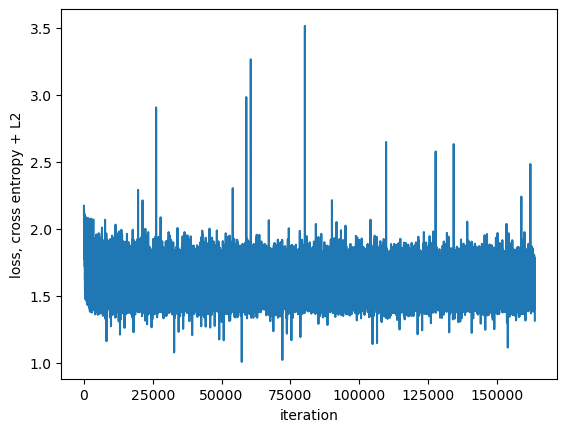

In [18]:
plt.plot(loss_list) 
plt.xlabel('iteration')
plt.ylabel('loss, cross entropy + L2')

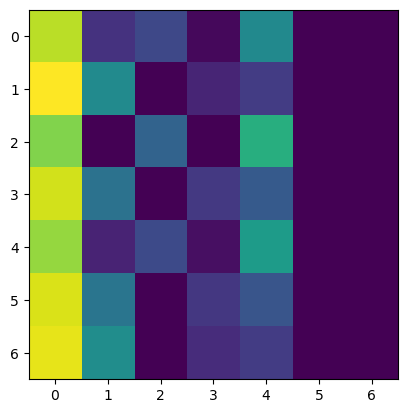

In [19]:
from sklearn.metrics import confusion_matrix

plt.imshow(confusion_matrix(real_labels, predicted_labels, normalize = 'true'))

In [20]:
confusion_matrix(real_labels, predicted_labels)

array([[1679,  275,  410,   41,  888,    0,    0],
       [ 574,  274,    0,   59,  101,    0,    0],
       [1118,    0,  440,    0,  868,    0,    0],
       [ 522,  212,    0,   93,  159,    0,    0],
       [1664,  196,  443,   84, 1080,    0,    0],
       [ 534,  220,    0,   91,  148,    0,    0],
       [ 506,  258,    0,   66,   93,    0,    0]])

In [21]:
#save model for the future in case
with open('models/cnn_model_rotations.pkl', 'wb') as f:
    pickle.dump(model, f)

In [22]:
for i, layer in enumerate(model.parameters()):
    print(f'layer {i} num of params: {torch.numel(layer)}')

layer 0 num of params: 576
layer 1 num of params: 64
layer 2 num of params: 18432
layer 3 num of params: 32
layer 4 num of params: 6720
layer 5 num of params: 7
layer 6 num of params: 49
layer 7 num of params: 7
